In [220]:
locals().clear()
globals().clear()

In [221]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import SubsetRandomSampler
import numpy as np
import random 
from random import shuffle
import matplotlib.pyplot as plt


# Define constants
num_classes = 10
learning_rate = 0.0001
num_epochs = 1000

# Load the MNIST dataset
training_dataset = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=transforms.Compose(
        [
            transforms.ToTensor(),  # convert the image to tensor
            transforms.Normalize((0.1307,), (0.3081,)),  # normalize
        ]
    ),
)

# Load the entire dataset in a nice format
X = training_dataset.data.reshape(-1, 28 * 28).float()
y = training_dataset.targets

# Shuffle
ind = np.random.permutation(len(training_dataset))
X = X[ind]
y = y[ind]

# Create a subset with equal number of examples for each class
subset_indices = []
class_counts = [0] * num_classes
M = 300  # Example subset size
for i in range(len(training_dataset)):
    label = y[i]
    if class_counts[label] < M // num_classes:
        subset_indices.append(i)
        class_counts[label] += 1
    if all(count == M // num_classes for count in class_counts):
        break
        
class LogRegression(nn.Module):
    """Multimodal logistic regression model"""

    def __init__(self):
        super(LogRegression, self).__init__()
        self.linear = nn.Linear(28 * 28, 10, bias=True)

    def forward(self, x, verbose=False):
        out = self.linear(x)
        return out

model = LogRegression()

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

v1 = []
v2 = []
v3 = []

# Training loop
for epoch in range(num_epochs):
    print(f'Iteration: {epoch+1}')
    
    gradient_list = []
    all_gradients = []
    for _ in range(10):
        gradient_list.append(torch.zeros(7840))
        all_gradients.append([])

    gradient_sum = torch.zeros(7840)
    for index in subset_indices:
        image = X[index]
        label = y[index]
        model.zero_grad()
        output = model(image)
        loss=criterion(output, label)
        loss.backward()
        gradient = []
        for name, param in model.named_parameters():
            if 'weight' in name:  # Only consider parameters associated with weights
                #if param.requires_grad and param.grad is not None:
                gradient.append(param.grad)
                    
        gradient=torch.stack(gradient).view(-1)
        all_gradients[label].append(gradient)
        gradient_list[label]+=gradient
        gradient_sum+=gradient

    # sum_diff = 0
    # for i in range(0, num_classes-1):      
    #     for j in range(i+1, num_classes):
    #         for i1 in range(M // num_classes):
    #             for j1 in range(M // num_classes):
    #                 sum_diff+=2*torch.dot(all_gradients[i][i1],all_gradients[j][j1])
            
    print(f'Squared L2 Norm of Full Gradient: {gradient_sum.norm().item() ** 2}')
    v1.append(gradient_sum.norm().item() ** 2)
    
    sum = 0
    for gr in gradient_list:
        sum += gr.norm().item() ** 2

    print(f'Sum of scalar products for gradients in same class: {sum}')
    v2.append(sum)
    
    print(f'Sum of scalar products for gradients in different class: {gradient_sum.norm().item() ** 2 - sum}')  
    v3.append(gradient_sum.norm().item() ** 2 - sum)
    
        
    images = X[subset_indices]
    labels = y[subset_indices]
    
    model.zero_grad()
    
    # Forward pass
    output = model(images)
        
    # Compute loss
    loss = criterion(output, labels.type(torch.long))

    # Backward pass
    loss.backward()

    # Optimize
    optimizer.step()

    # Print comparison and loss after each epoch
    print(f'Loss: {loss.item()}')
    print("\n")

Iteration: 1
Squared L2 Norm of Full Gradient: 37268453320.46509
Sum of scalar products for gradients in same class: 31729373617.60672
Sum of scalar products for gradients in different class: 5539079702.858368
Loss: 74.95245361328125


Iteration: 2
Squared L2 Norm of Full Gradient: 17080578565.972656
Sum of scalar products for gradients in same class: 28108120367.99756
Sum of scalar products for gradients in different class: -11027541802.024902
Loss: 54.22277069091797


Iteration: 3
Squared L2 Norm of Full Gradient: 11182722119.777588
Sum of scalar products for gradients in same class: 24542971992.455017
Sum of scalar products for gradients in different class: -13360249872.67743
Loss: 42.149505615234375


Iteration: 4
Squared L2 Norm of Full Gradient: 8444399548.062073
Sum of scalar products for gradients in same class: 21900292830.845398
Sum of scalar products for gradients in different class: -13455893282.783325
Loss: 34.15021896362305


Iteration: 5
Squared L2 Norm of Full Gradient:

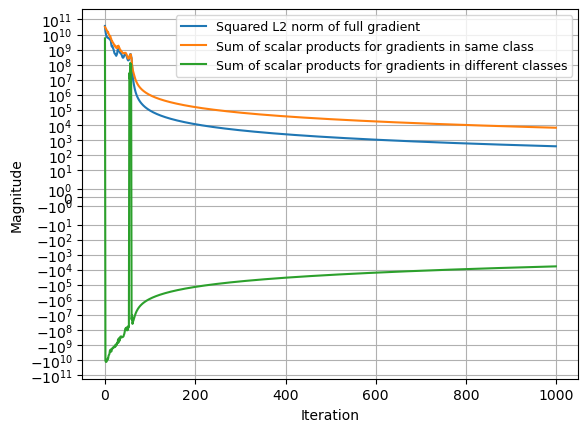

In [234]:
plt.plot(range(num_epochs),v1, label='Squared L2 norm of full gradient')
plt.plot(range(num_epochs),v2, label='Sum of scalar products for gradients in same class')
plt.plot(range(num_epochs),v3, label='Sum of scalar products for gradients in different classes')
plt.yscale('symlog')
plt.xlabel('Iteration')
plt.ylabel('Magnitude')
plt.legend(loc='upper right',fontsize=9)
plt.grid()